In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import numpy as np
import pickle
import time
import warnings

# sql and datetime imports and graphing func
from sqlalchemy import create_engine
# sklearn imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, auc, f1_score
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score, roc_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
# xgboost imports
from xgboost import XGBClassifier, plot_importance

In [2]:
# graphing functions
# function to plot the ROC curve
def plot_roc(name, clf, y_test, X_test):
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.3f)' % (name, roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
   #plt.savefig('Log_ROC')
    plt.show()
    return fpr, tpr, thresholds
# function to plot mult ROC curves
def plot_mult_roc(names, clfs, y_test, X_test):
    plt.figure(0).clf()
    for name, clf in zip(names, clfs):
        fprs = []
        tprs = []
        fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
        fprs.append(fpr)
        tprs.append(tpr)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s (AUC = %0.3f)' % (name, roc_auc))
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
   #plt.savefig('Log_ROC')
    plt.show()

In [3]:
# gain the ability to see all rows/columns if desired
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# ignore warnings
warnings.filterwarnings("ignore")  

In [4]:
# create sql engine for stock database
engineStocks = create_engine("sqlite:///stocks_old.db")
# assign the database to pandas df
stocks_df = pd.read_sql('''SELECT * FROM "stocks_table"''', engineStocks)

In [5]:
# create sql engine for spy database
engineSpy = create_engine("sqlite:///spy.db")
# assign the database to pandas df
spy_df = pd.read_sql('''SELECT * FROM "spy_table"''', engineSpy)

In [6]:
# merge stocks_df and spy_df
df = pd.merge(stocks_df, spy_df, left_on=['dateBreachedF1'], right_on=['full_date'], how='left')

In [7]:
df.head()

,ticker,year,quarter,yearStuck,yearGreen,pivotGreenYear,quarterStuck,quarterGreen,pivotGreenQuarter,revStratUp,mgbuy,timeBreached,threeMoLow,sixMoLow,threeMoHigh,sixMoHigh,stuckInTheMiddle,cmpndStuck,stuck,combo,month,dateBreachedF1,perCapture,perRisk,riskReward,threeMoChng,target,full_date,spyMoStuck,spyMoGreen,spyMoAbovePivot,spyQtrStuck,spyQtrGreen,spyQtrAbovePivot,spyMoHighQtr,spyYrStuck,spyYrGreen,spyYrAbovePivot,spyMoHighYr
0,AAPL,2002,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0,0,2,0,0,1,0,1,1,1,1,2002-03,2002-04-16,2.7,8.0,0.34,-30.0,Success,2002-04-16,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,AAPL,2003,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0,1,1,1,1,0,0,1,0,0,12U,2003-04,2003-05-05,2.3,6.4,0.36,41.0,Success,2003-05-05,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,AAPL,2004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,1,0,0,1,0,1,1,1,1,2004-02,2004-03-01,3.1,1.0,3.10,16.4,Failure,2004-03-01,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,AAPL,2004,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0,0,1,0,0,1,1,0,1,1,1,2004-05,2004-06-02,2.8,4.1,0.68,19.8,Success,2004-06-02,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
4,AAPL,2004,3.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0,2,0,0,1,1,1,1,1,1,2004-07,2004-08-26,1.7,11.7,0.15,55.8,Success,2004-08-26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# check out how many success/failures there are in the dataset
df['target'].value_counts()

Success         52381
Failure         24967
StillWorking     4353
Name: target, dtype: int64

In [9]:
## transform the data so it is ready for modeling
# make sure year column is float
df['year'] = df['year'].astype(float)
# remove the year from the month and return month only as an int
df['monthDigit'] = df['month'].apply(lambda x: int(x.split('-')[1]))
# drop column not needed
df = df.drop('dateBreachedF1', axis=1)
# turn target column into binary variables
df['target'] = df['target'].apply(lambda x: 1 if x == 'Success' or x == 'StillWorking' else 0)
# move the target column to the first position (out of the middle)
first_col = df.pop('target')
df.insert(0, 'target', first_col)
# remove any rows with risk greater than 100% and less than 0%
df = df[(df['perRisk'] <= 100) & (df['perRisk'] >= 0)]

In [10]:
# use all data except for the most recent month in order to test Sept and see how it performed
df_model = df[(df['monthDigit'] != 9) & (df['year'] != 2021)]
# drop not needed columns and highly correlated columns
df_model = df_model.drop(['threeMoChng', 'perCapture', 'perRisk', 'revStratUp', 'month', 'ticker', 'full_date'], axis=1)
# get all dummy variables from the dataframe
df_model = pd.get_dummies(df_model)
# remove all np.inf variables from the dataframe so the data can be modeleded properly
df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [11]:
df_model.shape

(69746, 41)

In [12]:
df_model.head()

,target,year,quarter,yearStuck,yearGreen,pivotGreenYear,quarterStuck,quarterGreen,pivotGreenQuarter,mgbuy,timeBreached,threeMoLow,sixMoLow,threeMoHigh,sixMoHigh,stuckInTheMiddle,cmpndStuck,stuck,riskReward,spyMoStuck,spyMoGreen,spyMoAbovePivot,spyQtrStuck,spyQtrGreen,spyQtrAbovePivot,spyMoHighQtr,spyYrStuck,spyYrGreen,spyYrAbovePivot,spyMoHighYr,monthDigit,combo_1,combo_11,combo_111,combo_12U,combo_22U,combo_2xHam,combo_31,combo_312U,combo_32U,combo_PMG
0,1,2002.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0,2,0,0,1,0,1,1,1,0.34,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,1,0,0,0,0,0,0,0,0,0
1,1,2003.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,1,1,0,0,1,0,0,0.36,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,4,0,0,0,1,0,0,0,0,0,0
2,0,2004.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,1,0,1,1,1,3.10,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2,1,0,0,0,0,0,0,0,0,0
3,1,2004.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0,1,0,0,1,1,0,1,1,0.68,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,5,1,0,0,0,0,0,0,0,0,0
4,1,2004.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,0,2,0,0,1,1,1,1,1,0.15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1,0,0,0,0,0,0,0,0,0


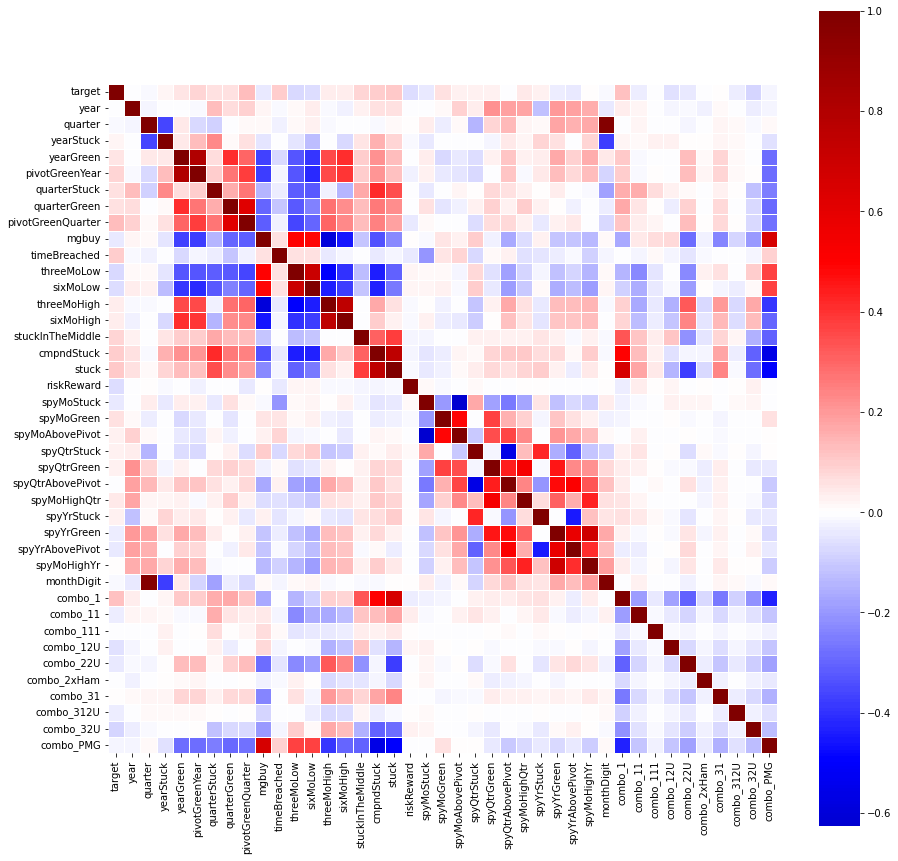

In [13]:
# check out correlation of features using a heatmap
plt.figure(figsize=(15,15))
sns.heatmap(df_model.corr(), center=0, cmap='seismic', square=True, linewidth=-1, vmax=1);

In [14]:
df_model.shape

(69746, 41)

In [15]:
# assign X and y variables
X = df_model.iloc[:, 1:]
y = df_model.iloc[:, 0]

In [16]:
# perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [17]:
# scale the data for use in all models
std_scale = StandardScaler()
X_scaled = std_scale.fit_transform(X)
X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

### KNN Model
KNN took a very long time to run, so I abandoned further testing with it

In [18]:
# # run a KNN model
# knn = KNeighborsClassifier(n_neighbors=5)

# knn.fit(X_train_scaled, y_train)
# y_predict = knn.predict(X_test_scaled)

# print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))

In [19]:
# # find optimal k  --> did not complete, took way too long to calc
# k_range = range(2,16)
# scores = []
# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, X_scaled, y, cv=10, scoring='accuracy')
#     k_scores.append(scores.mean())

# # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(k_range, k_scores)
# plt.xlabel('Value of K for KNN')
# plt.ylabel('Cross-Validated Accuracy');

In [20]:
# # classification report knn TRAIN DATA
# y_predict = knn.predict(X_train_scaled)
# print(classification_report(y_train, y_predict)

In [21]:
# # classification report knn TEST DATA
# y_predict = knn.predict(X_test_scaled)
# print(classification_report(y_test, y_predict))

In [22]:
# knn_fpr, knn_tpr, knn_thresholds = plot_roc("k-Nearest Neighbours", knn, y_test, X_test_scaled)

### Logistic Regression

In [23]:
log = LogisticRegression()

log.fit(X_train_scaled, y_train)
y_predict = log.predict(X_test_scaled)

print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))

Accuracy Score: 0.7327598566308243


In [24]:
# classification report TEST log
y_predict = log.predict(X_test_scaled) 
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.66      0.29      0.40      4333
           1       0.74      0.93      0.83      9617

    accuracy                           0.73     13950
   macro avg       0.70      0.61      0.62     13950
weighted avg       0.72      0.73      0.70     13950



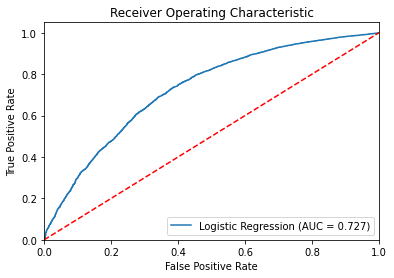

In [25]:
log_fpr, log_tpr, log_thresholds = plot_roc("Logistic Regression", log, y_test, X_test_scaled)

#### Calculate feature importance for Log Reg

In [26]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': log.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

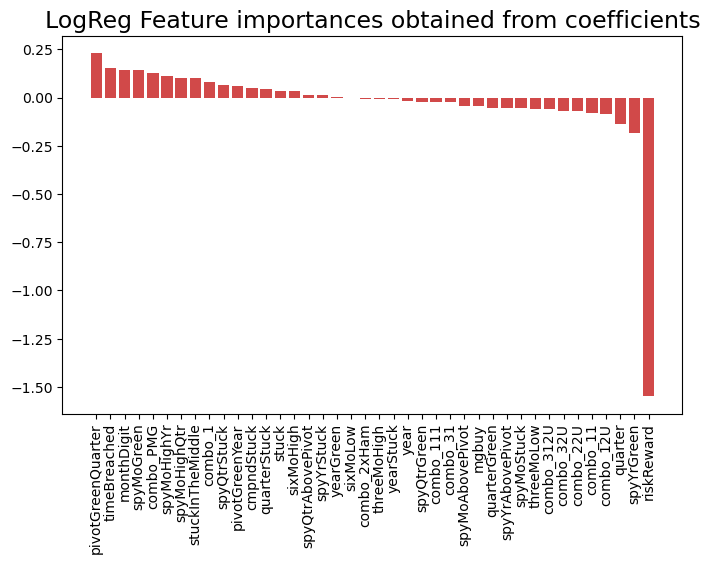

In [27]:
plt.figure(figsize=(8,5), dpi=100)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#d14949')
plt.title('LogReg Feature importances obtained from coefficients', size=17)
plt.xticks(rotation='vertical')
plt.show()

#### Logistic Regression Balanced

In [28]:
#balanced logistic regression testing classification report
log_balanced = LogisticRegression(class_weight = 'balanced')

log_balanced.fit(X_train_scaled, y_train)
y_predict = log_balanced.predict(X_test_scaled)

print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))

Accuracy Score: 0.7212186379928316


In [29]:
# classification report TEST log balanced
y_predict = log_balanced.predict(X_test_scaled)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.55      0.56      0.55      4333
           1       0.80      0.80      0.80      9617

    accuracy                           0.72     13950
   macro avg       0.67      0.68      0.68     13950
weighted avg       0.72      0.72      0.72     13950



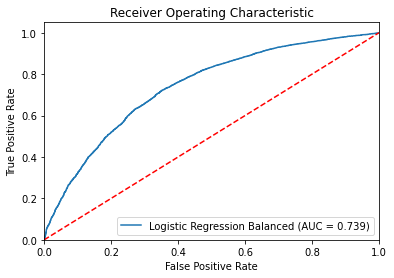

In [30]:
log_balanced_fpr, log_balanced_tpr, log_balanced_thresholds = plot_roc("Logistic Regression Balanced", log_balanced, y_test, X_test_scaled)

Balanced not better than basic log reg, will stick with basic log reg.

### Random Forest

In [31]:
rf = RandomForestClassifier()

rf.fit(X_train_scaled, y_train)
y_predict = rf.predict(X_test_scaled)

print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))

Accuracy Score: 0.7424372759856631


In [32]:
# classification report TEST random forest
y_predict = rf.predict(X_test_scaled)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.65      0.38      0.48      4333
           1       0.76      0.91      0.83      9617

    accuracy                           0.74     13950
   macro avg       0.70      0.64      0.65     13950
weighted avg       0.73      0.74      0.72     13950



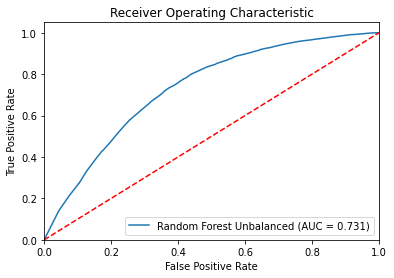

In [33]:
rf_fpr, rf_tpr, rf_thresholds = plot_roc("Random Forest Unbalanced", rf, y_test, X_test_scaled)

In [34]:
rf_balanced = RandomForestClassifier(class_weight='balanced')

rf_balanced.fit(X_train_scaled, y_train)
y_predict = rf_balanced.predict(X_test_scaled)

print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))

Accuracy Score: 0.7425089605734767


In [35]:
# classification report TEST random forest balanced
y_predict = rf_balanced.predict(X_test_scaled)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.65      0.36      0.47      4333
           1       0.76      0.91      0.83      9617

    accuracy                           0.74     13950
   macro avg       0.71      0.64      0.65     13950
weighted avg       0.73      0.74      0.72     13950



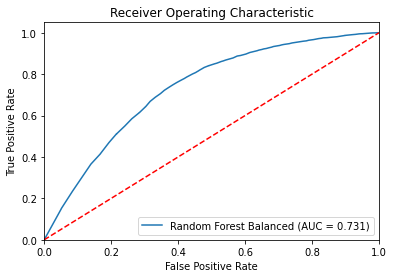

In [36]:
rf_balanced_fpr, rf_balanced_tpr, rf_balanced_thresholds = plot_roc("Random Forest Balanced", rf_balanced, y_test, X_test_scaled)

Balanced not better than basic random forest, will stick with basic random forest.

#### Calculate feature importance for Random Forest

In [37]:
# calculate the permutation on full model to identify the features with the highest impact \
# for our rf model, which has given us the best R^2 and best RMSE
feature_names = [f'{i}' for i in X_train.columns]
result = permutation_importance(rf, X_train_scaled, y_train, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)
forest_importances = forest_importances[:25]

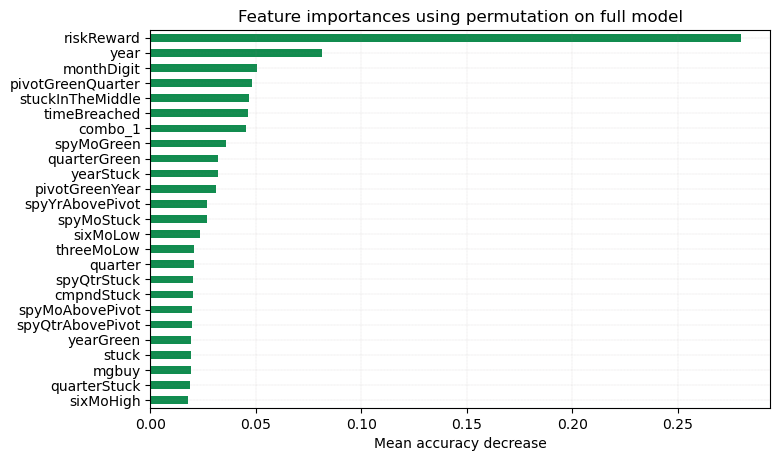

In [38]:
# bar plot for permutation impact
plt.figure(figsize=(8,5), dpi=100)
forest_importances.plot.barh(yerr=result, color='#118C4F')
plt.title("Feature importances using permutation on full model")
plt.xlabel("Mean accuracy decrease")
plt.gca().invert_yaxis()
plt.grid(color='#948789', linestyle='-.', linewidth=0.1);

### XGBoost

In [39]:
xgb = XGBClassifier(eval_metric='logloss')

xgb.fit(X_train_scaled, y_train)
y_predict = xgb.predict(X_test_scaled)

print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))

Accuracy Score: 0.751326164874552


In [40]:
# classification report TEST XGBoost
y_predict = xgb.predict(X_test_scaled)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50      4333
           1       0.77      0.91      0.83      9617

    accuracy                           0.75     13950
   macro avg       0.72      0.66      0.67     13950
weighted avg       0.74      0.75      0.73     13950



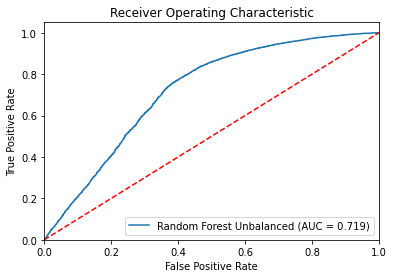

In [41]:
xgb_fpr, xgb_tpr, xgb_thresholds = plot_roc("Random Forest Unbalanced", xgb, y_test, X_test_scaled)

In [42]:
dtrain = xgboost.DMatrix( X, label=y)
feature_name_list = dtrain.feature_names

#### Calculate feature importance for XGBoost

In [43]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

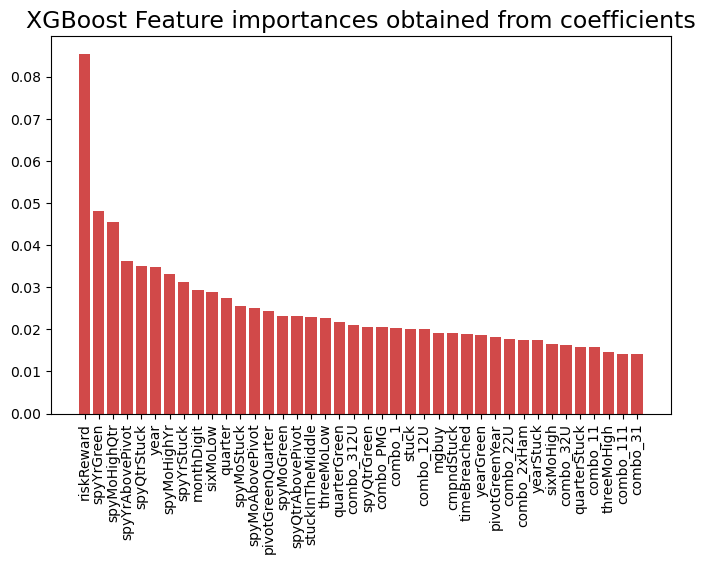

In [44]:
plt.figure(figsize=(8,5), dpi=100)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#d14949')
plt.title('XGBoost Feature importances obtained from coefficients', size=17)
plt.xticks(rotation='vertical')
plt.show()

### Gaussian Naive Bayes

In [45]:
# Naive Bayes
gnb = GaussianNB()

gnb.fit(X_train_scaled, y_train)
y_predict = gnb.predict(X_test_scaled)

print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))

Accuracy Score: 0.6293906810035842


In [46]:
# classification report TEST naive bayes
y_predict = gnb.predict(X_test_scaled)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.40      0.41      0.41      4333
           1       0.73      0.73      0.73      9617

    accuracy                           0.63     13950
   macro avg       0.57      0.57      0.57     13950
weighted avg       0.63      0.63      0.63     13950



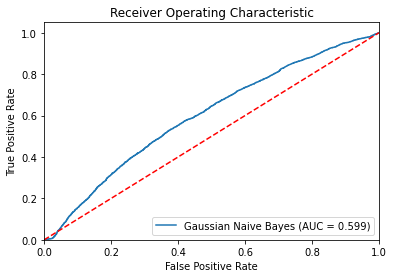

In [47]:
nb_fpr, nb_tpr, nb_thresholds = plot_roc("Gaussian Naive Bayes", gnb, y_test, X_test_scaled)

### Support Vector Machine

In [48]:
# run Support Vector Machine
svm = SVC(probability = True)

svm.fit(X_train_scaled, y_train)
y_predict = svm.predict(X_test_scaled)

print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))

Accuracy Score: 0.7377060931899642


In [49]:
# classification report TEST support vector machine
y_predict = svm.predict(X_test_scaled)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.67      0.31      0.42      4333
           1       0.75      0.93      0.83      9617

    accuracy                           0.74     13950
   macro avg       0.71      0.62      0.63     13950
weighted avg       0.72      0.74      0.70     13950



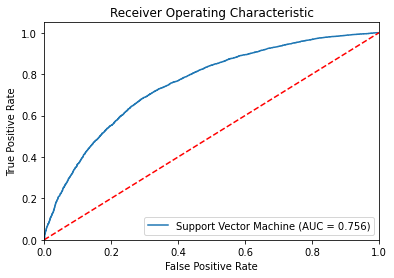

In [50]:
svm_fpr, svm_tpr, svm_thresholds = plot_roc("Support Vector Machine", svm, y_test, X_test_scaled)

### Plot every model's ROC

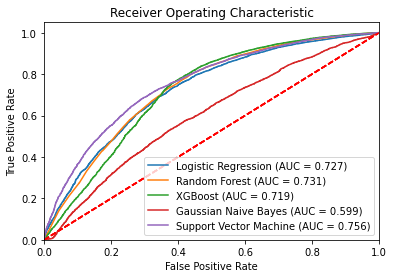

In [51]:
plot_mult_roc(['Logistic Regression', 'Random Forest', 'XGBoost', 'Gaussian Naive Bayes', 'Support Vector Machine'], [log, rf, xgb, gnb, svm], y_test, X_test_scaled)

# Optimize Models

#### Log Regression

In [52]:
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,.009,0.01,.09,1,5,10,25,50,75,100,250,500,1000,1500]
}

In [53]:
log_grid_search = GridSearchCV(
        estimator=log,
        param_grid=parameters,
        scoring = 'precision',
        n_jobs = 10,
        cv = 10, 
        verbose = 0, 
)

In [54]:
start_time = time.time()
log_grid_search.fit(X_train_scaled,y_train)
print("This took", round((time.time() - start_time)/60, 2), "minutes to run.")

This took 0.3 minutes to run.


In [55]:
log_grid_search.best_estimator_.get_params()

{'C': 1500,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [56]:
tuned_log = LogisticRegression(
        C = 5,
        penalty = 'l2'
)

In [57]:
tuned_log.fit(X_train_scaled, y_train)
y_predict = tuned_log.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, y_predict))
print('Precision Score:', precision_score(y_test,y_predict))
print('Recall Score:', recall_score(y_test,y_predict))
print('F1 Score:', f1_score(y_test,y_predict))

Accuracy Score: 0.7327598566308243
Precision Score: 0.744742747901255
Recall Score: 0.9316834771758344
F1 Score: 0.8277900960827789


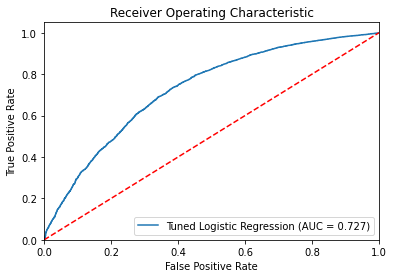

In [58]:
tuned_log_fpr, tuned_log_tpr, tuned_log_thresholds = plot_roc("Tuned Logistic Regression", tuned_log, y_test, X_test_scaled)

#### Random Forest

In [59]:
parameters = {
    'bootstrap': [True], 
    'max_depth': [None],
    'max_features': ['auto', 'log2'], 
    'n_estimators': [250]
}

In [60]:
rf_grid_search = GridSearchCV(
        estimator=rf,
        param_grid=parameters,
        scoring = 'precision',
        n_jobs = 10,
        cv = 10, 
        verbose = 0, 
)

In [61]:
start_time = time.time()
rf_grid_search.fit(X_train_scaled,y_train)
print("This took", round((time.time() - start_time)/60, 2), "minutes to run.")

This took 1.33 minutes to run.


In [62]:
rf_grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [63]:
tuned_rf = RandomForestClassifier(
    bootstrap = True, 
    max_depth = None, 
    max_features = 'auto',
    n_estimators = 250
)

In [64]:
tuned_rf.fit(X_train_scaled, y_train)
y_predict = tuned_rf.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, y_predict))
print('Precision Score:', precision_score(y_test,y_predict))
print('Recall Score:', recall_score(y_test,y_predict))
print('F1 Score:', f1_score(y_test,y_predict))

Accuracy Score: 0.7445878136200716
Precision Score: 0.7645979020979021
Recall Score: 0.9095351980867215
F1 Score: 0.8307926105333144


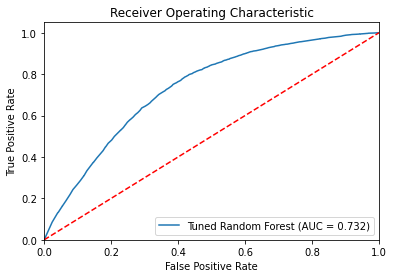

In [65]:
tuned_rf_fpr, tuned_rf_tpr, tuned_rf_thresholds = plot_roc("Tuned Random Forest", tuned_rf, y_test, X_test_scaled)

#### XGBoost

In [66]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [67]:
parameters = {
    'max_depth': range(2, 8, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.05, 0.1, 0.2]
}

In [68]:
xgb_grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [69]:
start_time = time.time()
xgb_grid_search.fit(X_train_scaled, y_train)
print("This took", round((time.time() - start_time)/60, 2), "minutes to run.")

Fitting 10 folds for each of 72 candidates, totalling 720 fits
This took 7.41 minutes to run.


In [70]:
xgb_grid_search.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 180,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'nthread': 4,
 'seed': 42,
 'eval_metric': 'logloss'}

In [71]:
tuned_xgb = XGBClassifier(
        objective= 'binary:logistic',
        nthread=4,
        seed=42,
        use_label_encoder=False,
        eval_metric='logloss',
        max_depth=6,
        n_estimators=180,
        learning_rate=0.1
    )

In [72]:
tuned_xgb.fit(X_train_scaled, y_train)
y_predict = tuned_xgb.predict(X_test_scaled)

print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))

Accuracy Score: 0.752831541218638


In [73]:
# classification report TEST Tuned XGBoost
y_predict = tuned_xgb.predict(X_test_scaled)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.67      0.41      0.50      4333
           1       0.77      0.91      0.84      9617

    accuracy                           0.75     13950
   macro avg       0.72      0.66      0.67     13950
weighted avg       0.74      0.75      0.73     13950



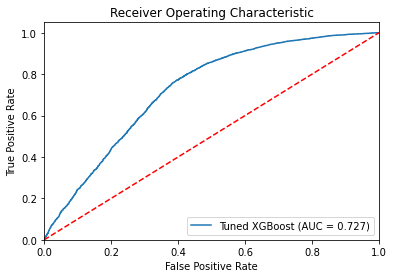

In [74]:
tuned_xgb_fpr, tuned_xgb_tpr, tuned_xgb_thresholds = plot_roc("Tuned XGBoost", tuned_xgb, y_test, X_test_scaled)

#### Support Vector Machine

In [75]:
# parameters = {
#     'C': [0.1, 100, 1000],
#     'gamma': [.01,.1,1],
#     'kernel': ['rbf', 'poly', 'sigmoid']
# }

In [76]:
# svm_random_grid_search = RandomizedSearchCV(
#     estimator=svm,
#     param_distributions=parameters,
#     scoring = 'precision',
#     n_jobs = 10,
#     cv = 10,
#     verbose=True
# )

In [77]:
# start_time = time.time()
# svm_random_grid_search.fit(X_train_scaled, y_train)
# print("This took", round((time.time() - start_time)/60, 2), "minutes to run.")

In [78]:
# svm_random_grid_search.best_estimator_.get_params()

In [79]:
# tuned_svc = SVC(
#     probability = True
#     C = 
#     gamma = 
#     kernel =
# )

In [80]:
# tuned_svc.fit(X_train_scaled, y_train)
# y_predict = tuned_svc.predict(X_test_scaled)

# print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))

In [81]:
# # classification report TEST Tuned SVC
# y_predict = tuned_svc.predict(X_test_scaled)
# print(classification_report(y_predict, y_test))

In [82]:
# tuned_svc_fpr, tuned_svc_tpr, tuned_svc_thresholds = plot_roc("Tuned XGBoost", tuned_svc, y_test, X_test_scaled)

### Adjust Model Threshold For Random Forest

In [83]:
# adjust the threshold manually
threshold_rf = tuned_rf.predict_proba(X_train_scaled)
threshold = .34
modified_threshold_pred = np.where(threshold_rf > threshold, 1, 0).T[1].T
print(classification_report(y_train, modified_threshold_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     17241
           1       0.97      1.00      0.99     38555

    accuracy                           0.98     55796
   macro avg       0.99      0.97      0.98     55796
weighted avg       0.98      0.98      0.98     55796



In [84]:
# check out the model with the updated threshold 
tuned_rf.fit(X_train_scaled, y_train)
y_predict = tuned_rf.predict_proba(X_test_scaled)[:,1] > threshold

In [85]:
print("Accuracy Score:", metrics.accuracy_score(y_test, y_predict))
print('Precision Score:', precision_score(y_test,y_predict))
print('Recall Score:', recall_score(y_test,y_predict))
print('F1 Score:', f1_score(y_test,y_predict))

Accuracy Score: 0.7340501792114695
Precision Score: 0.7377827872152001
Recall Score: 0.9528959134865342
F1 Score: 0.8316544151011889


In [86]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.70      0.25      0.37      4333
           1       0.74      0.95      0.83      9617

    accuracy                           0.73     13950
   macro avg       0.72      0.60      0.60     13950
weighted avg       0.73      0.73      0.69     13950



In [87]:
confusion_matrix(y_test, y_predict)

array([[1076, 3257],
       [ 453, 9164]])

In [88]:
# The column 0 is the probability for class 0 and the column 1 is the probability for the class 1. 
# If you have n classes the output probabilities shape will be (n_examples, n_classes).
y_predict_print = tuned_rf.predict_proba(X_test_scaled)
y_predict_print

array([[0.012, 0.988],
       [0.232, 0.768],
       [0.08 , 0.92 ],
       ...,
       [0.056, 0.944],
       [0.056, 0.944],
       [0.472, 0.528]])

### Pickle the Model for Prediction Use

In [98]:
pickle.dump(tuned_rf, open('rf_model.pkl', 'wb'))